In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime

### Plotting Theme

In [58]:
#set matplotlib parameters
mp.rc_file_defaults()
rc = {'axes.facecolor':'white','grid.color': '.8',}
plt.rcParams.update(rc)

#set seaborn color palette
sns.set_palette(sns.color_palette("Reds", 6))
palette = ["#66b3ff","#ffb3b3","#ffff33","#eeccff","#1ac6ff"]

# 1. Loading Data

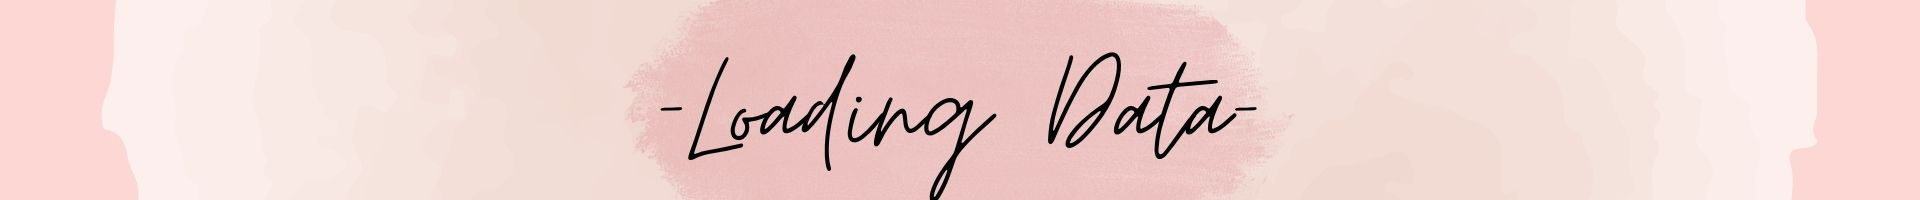

In [59]:
#Loading data file.

data = pd.read_excel("./Data/marketing_campaign.xlsx")
print("Data loaded with", len(data), "rows")
data.head()

Data loaded with 2240 rows


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


# 2. Data Cleaning

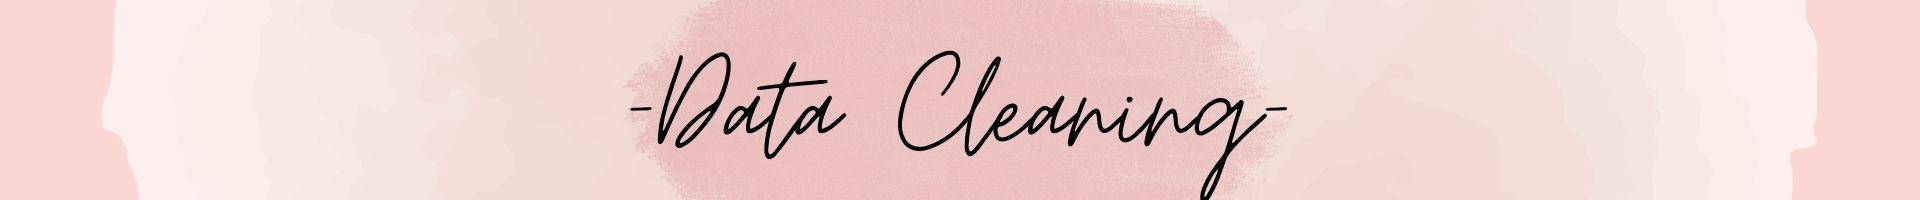

In [60]:
#overview of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Data cleaning steps:

*   Drop un-needed columns

*   Drop rows with empty income values (These 24 null values)

*   Change the Dt_Customer to a DateTime format



In [61]:
#drop un-needed columns
data= data.drop(["ID","Z_CostContact", "Z_Revenue"], axis=1)
#drop rows with missing values
data= data.dropna()
#change date format
data["Dt_Customer"]= pd.to_datetime(data["Dt_Customer"])

# 3. Preprocessing

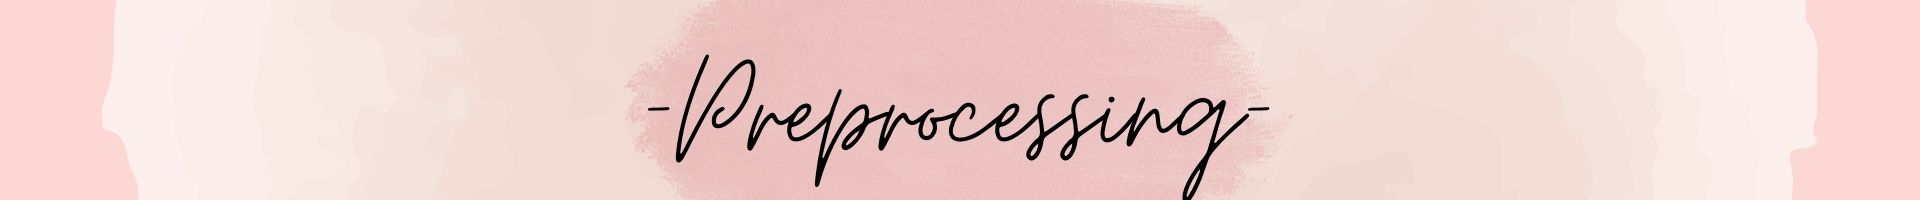

## 3.1. Data Transformation

We can also examine the values for categorial features 

In [62]:
#examining categorical data
print("Education Values: ", data["Education"].unique())
print("Marital_Status Values:", data["Marital_Status"].unique())

Education Values:  ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status Values: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [63]:
#give each feature a smaller set of values
#reducing the # of category 
edu= {"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"}
data["Education"]= data["Education"].replace(edu)

status= {"YOLO": "Single", "Absurd": "Single", "Alone": "Single", "Widow": "Single", "Divorced": "Single", "Together": "Taken", "Married": "Taken"}
data["Marital_Status"]= data["Marital_Status"].replace(status)

#updated categorical variables
print("Education Values: ", data["Education"].unique())
print("Marital_Status Values:", data["Marital_Status"].unique())

Education Values:  ['Graduate' 'Postgraduate' 'Undergraduate']
Marital_Status Values: ['Single' 'Taken']



We can then transform some of the features as follows:
Features reduction

In [64]:
#finding customer age
data["Age"]= datetime.now().year-data["Year_Birth"]

#finding family size and number of children
data["Children_Count"]= data["Kidhome"]+data["Teenhome"]
data["Family_Size"]= 1+data["Children_Count"]+data["Marital_Status"].replace({"Taken": 1, "Single": 0})

#finding number of days since person became a customer
data["Customer_For"]= (datetime.now()-data["Dt_Customer"]).dt.days

#finding total spendings of customer
data["Spendings"]= data["MntWines"]+data["MntFruits"]+data["MntFishProducts"]+data["MntMeatProducts"]+data["MntSweetProducts"]+data["MntGoldProds"]

#finding total number of purchases of customer
data["Purchases"]= data["NumDealsPurchases"]+data["NumWebPurchases"]+data["NumCatalogPurchases"]+data["NumStorePurchases"]

#finding total number of accepted campaigns
data["Accepted_Campaigns"]= data["AcceptedCmp1"]+data["AcceptedCmp2"]+data["AcceptedCmp3"]+data["AcceptedCmp4"]+data["AcceptedCmp5"]

#dropping un-needed columns
data= data.drop(["Year_Birth","Dt_Customer"],axis=1)


## 3.2. Outlier Removal

Now we need to check the distribution of values in the dataset to remove any outliers

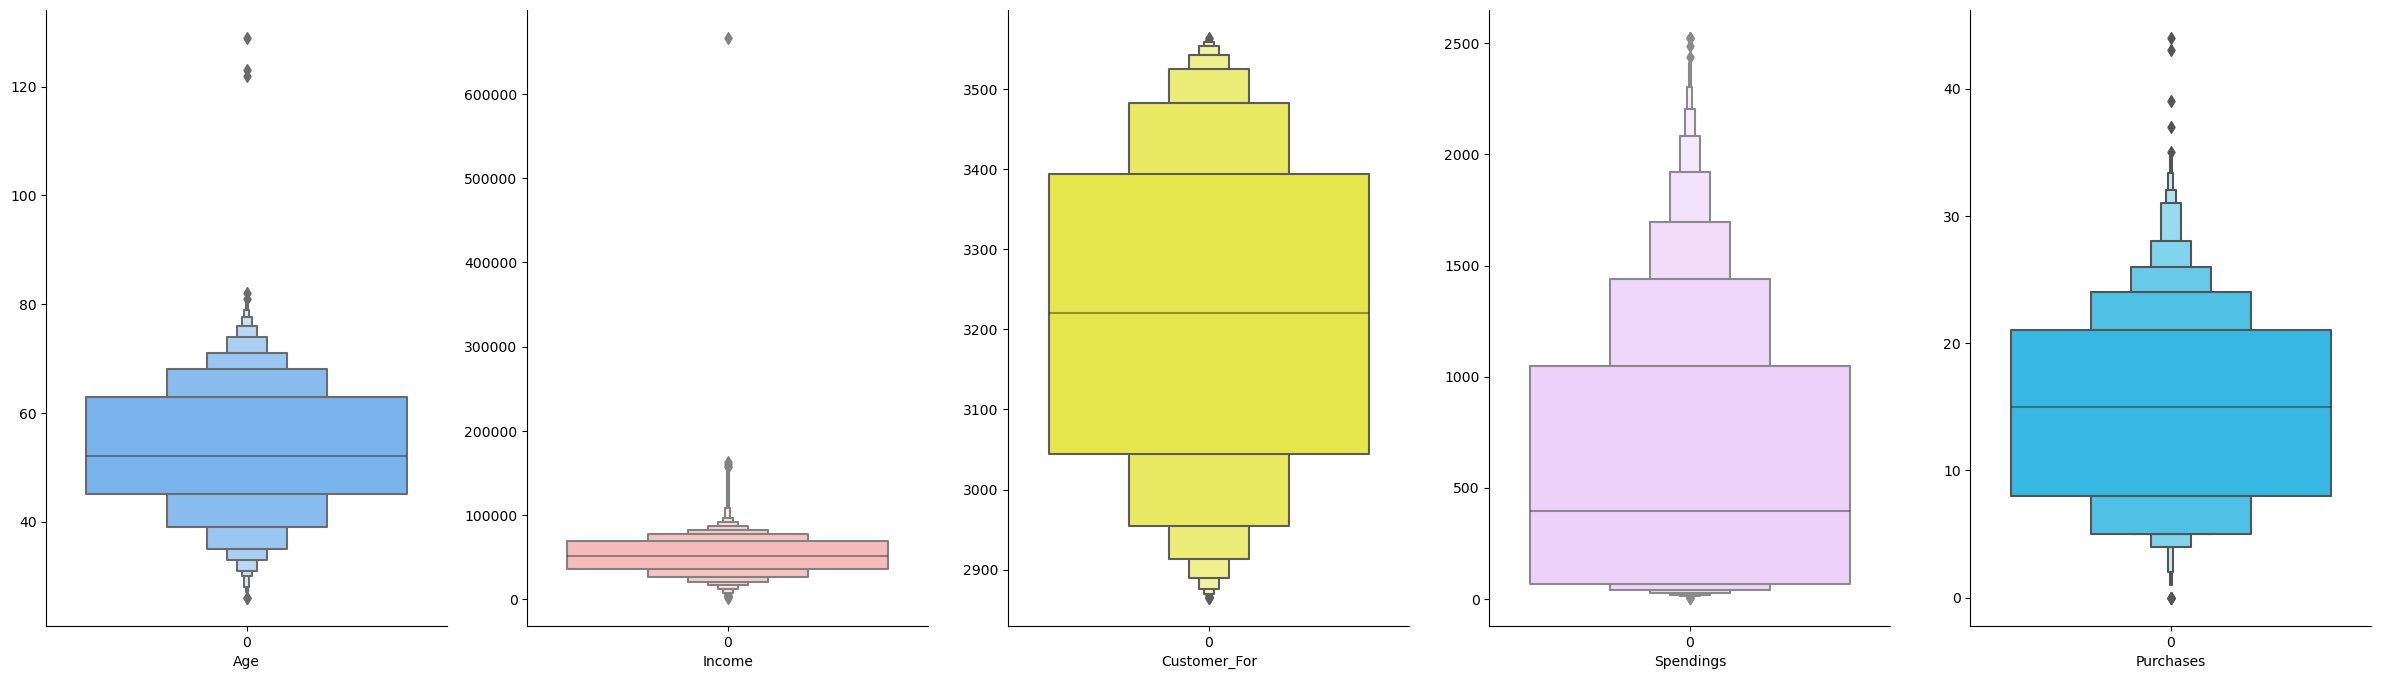

In [65]:
#examine the boxplots of different features
features= ["Age", "Income", "Customer_For", "Spendings", "Purchases"]

#create plots
fig, axs = plt.subplots(ncols=len(features),figsize=(6*len(features),8))
for i in range(len(features)):
  sns.boxenplot(data=data[features[i]],
                showfliers=True,
                ax=axs[i],
                palette=[palette[i]]
                ).set(xlabel=features[i])
  sns.despine()

In [66]:
#checking the number of outliers in age and income
print("Number of customers above the age of 100= ", len(data[data["Age"]>100]))
print("Number of customers with income above 200,000= ", len(data[data["Income"]>200000]))

Number of customers above the age of 100=  3
Number of customers with income above 200,000=  1


We can see some outliers in the age, income and purchases. Those in the age and income will be removed as they are very few data points. The ones in the purchases will be kept as the range of values is considerable.

In [67]:
data= data.drop(data[(data["Age"]>100) | (data["Income"]>200000)].index)
print("Current data points count= ",len(data))

Current data points count=  2212


Before moving forward, I will take a copy of the data to be used later in the analysis part. I will also drop some features that I used to create new features in the previous data transformation section.



In [68]:
dataCopy= data.copy()
data= data.drop(["Kidhome","Teenhome"],axis=1)

## 3.3. Encoding Categorical Features

The 2 categorial features we have can be encoded as follows:


*   Education: using a label encoder since it's considered ordinal
*   Marital_Status: using one hot encoding since it's considered nominal



In [69]:
#label encode education
encoder= LabelEncoder()
data["Education"]= data[["Education"]].apply(encoder.fit_transform)

#hot encode marital_status
data = pd.get_dummies(data)

#check data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Education              2212 non-null   int32  
 1   Income                 2212 non-null   float64
 2   Recency                2212 non-null   int64  
 3   MntWines               2212 non-null   int64  
 4   MntFruits              2212 non-null   int64  
 5   MntMeatProducts        2212 non-null   int64  
 6   MntFishProducts        2212 non-null   int64  
 7   MntSweetProducts       2212 non-null   int64  
 8   MntGoldProds           2212 non-null   int64  
 9   NumDealsPurchases      2212 non-null   int64  
 10  NumWebPurchases        2212 non-null   int64  
 11  NumCatalogPurchases    2212 non-null   int64  
 12  NumStorePurchases      2212 non-null   int64  
 13  NumWebVisitsMonth      2212 non-null   int64  
 14  AcceptedCmp3           2212 non-null   int64  
 15  Acce

## 3.4. Feature Scaling

Assuming that our features follow a normal distribution, a standard scaler will be used for scaling

In [70]:
#scale features
scaler= StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

#check
data.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Response,Age,Children_Count,Family_Size,Customer_For,Spendings,Purchases,Accepted_Campaigns,Marital_Status_Single,Marital_Status_Taken
0,-0.893586,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,...,2.375425,1.018352,-1.264598,-1.758359,1.527721,1.676245,1.317945,-0.43916,1.349603,-1.349603
1,-0.893586,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,...,-0.420977,1.274785,1.404572,0.449070,-1.189011,-0.963297,-1.159273,-0.43916,1.349603,-1.349603
2,-0.893586,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,...,-0.420977,0.334530,-1.264598,-0.654644,-0.206048,0.280110,0.796425,-0.43916,-0.740959,0.740959
3,-0.893586,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,...,-0.420977,-1.289547,0.069987,0.449070,-1.060584,-0.920135,-0.898513,-0.43916,-0.740959,0.740959
4,0.571657,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,...,-0.420977,-1.033114,0.069987,0.449070,-0.951915,-0.307562,0.535666,-0.43916,-0.740959,0.740959


#4. Dimensionality Reduction

## 4.1. Feature Extraction

Now let's take a look on the coorelation between features

<AxesSubplot:>

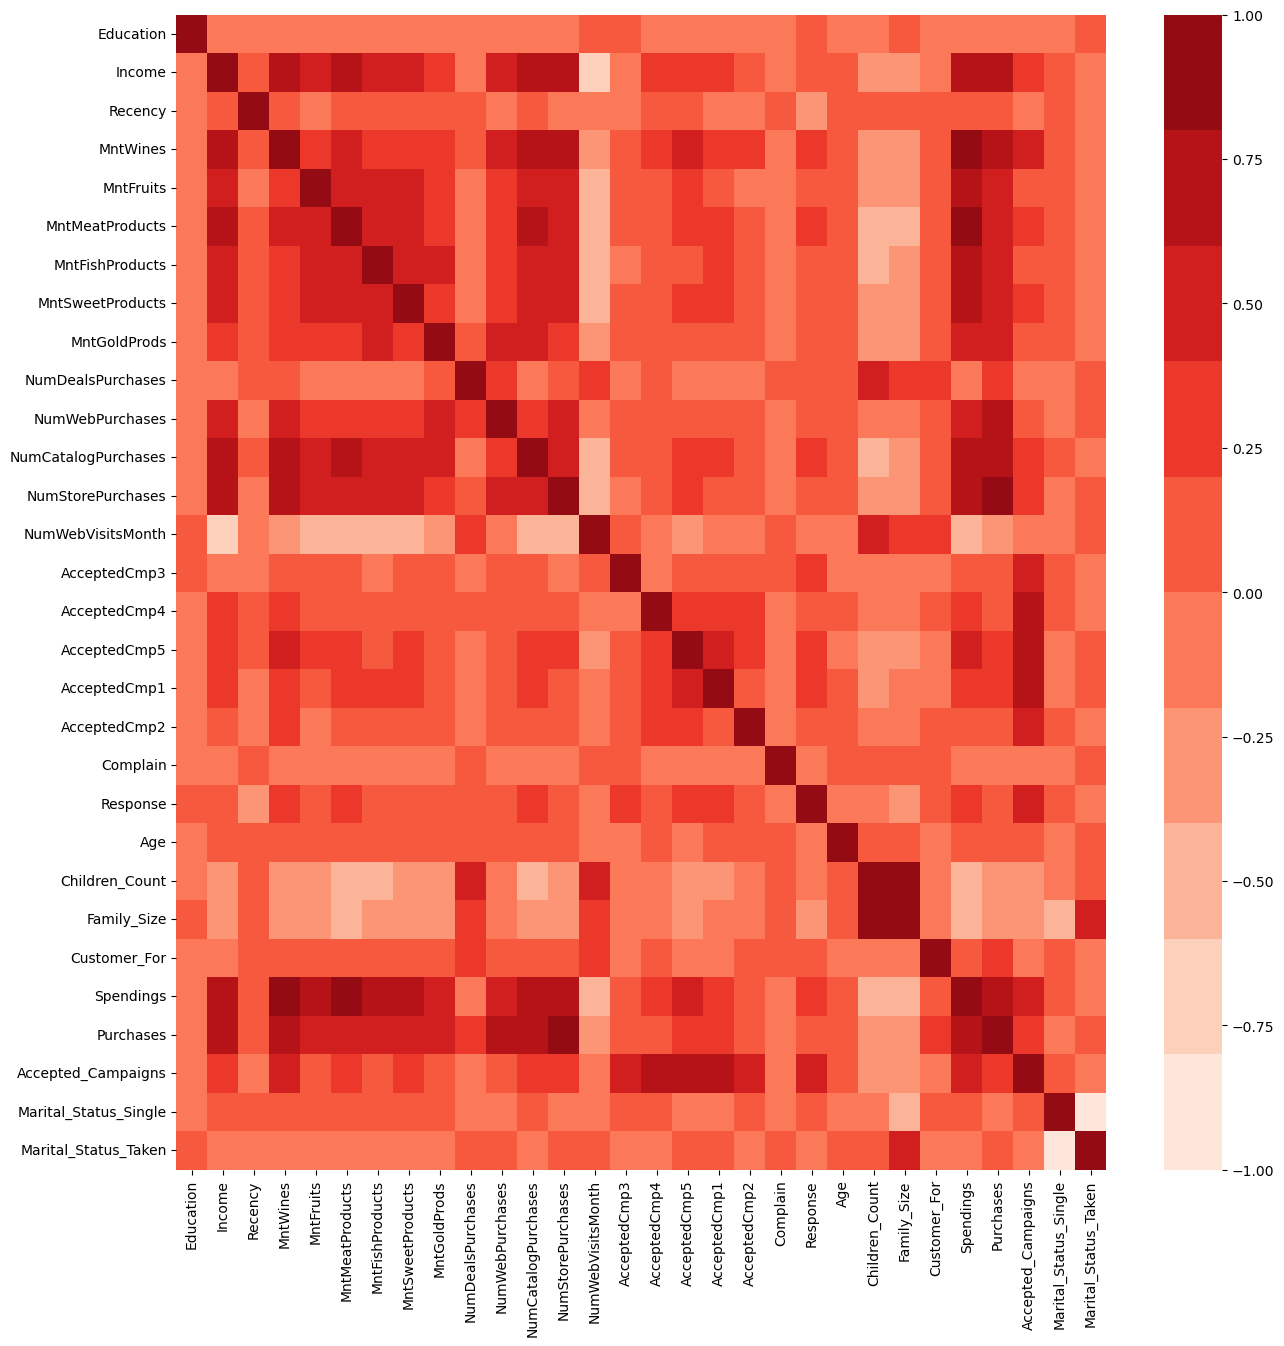

In [72]:
fig, ax = plt.subplots(figsize=(15,15))         
sns.heatmap(data.corr(),
            # cmap="YlGnBu",
            cmap= sns.color_palette("Reds", 10),
            ax=ax)

A lot of features have high correlation values. PCA will be used to reduce the dimensions while keeping 95% of the variations

In [73]:
#95% variations
pca = PCA(n_components = 0.95)
pca.fit(data)
reduced_data = pd.DataFrame(pca.transform(data))

print("Current number of features= ",len(reduced_data.columns))

Current number of features=  20


By keeping 95% of the variations, the number of features dropped from 32 to 20, but we want to reduce that even more to reduce complexity, so we will compromise more variations.

In [74]:
#75% variations
pca = PCA(n_components = 0.75)
pca.fit(data)
reduced_data = pd.DataFrame(pca.transform(data))

print("Current number of features= ",len(reduced_data.columns))

Current number of features=  10


# 4. Data Clustering

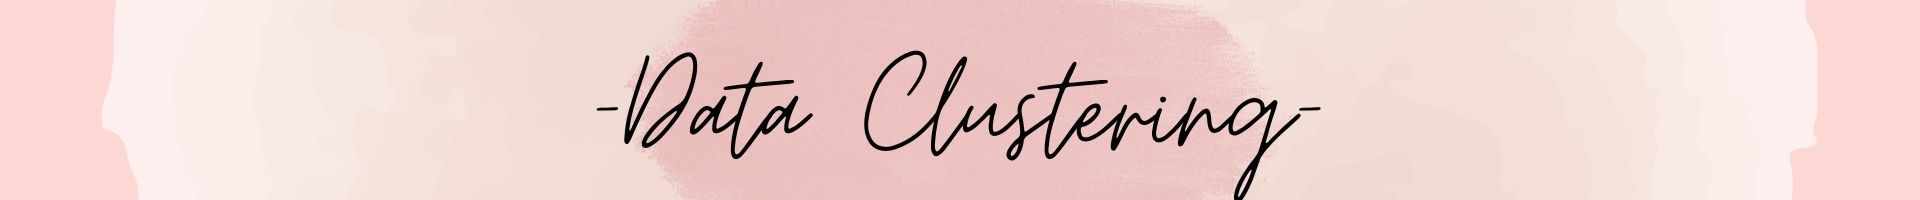

## 4.1. Optimal Number of Clusters

First, we need to have a good sense of how many clusters are in our dataset. To determine this, we will use the elbow method.

In [75]:
#calculate distortions for different values of k (number of clusters)
distortions = []
K = range(1,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(reduced_data)
    distortions.append(kmeanModel.inertia_)

C:\Users\mnkre\AppData\Local\Temp/ipykernel_22132/3206906214.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, distortions, 'bx-', color=palette[-1])


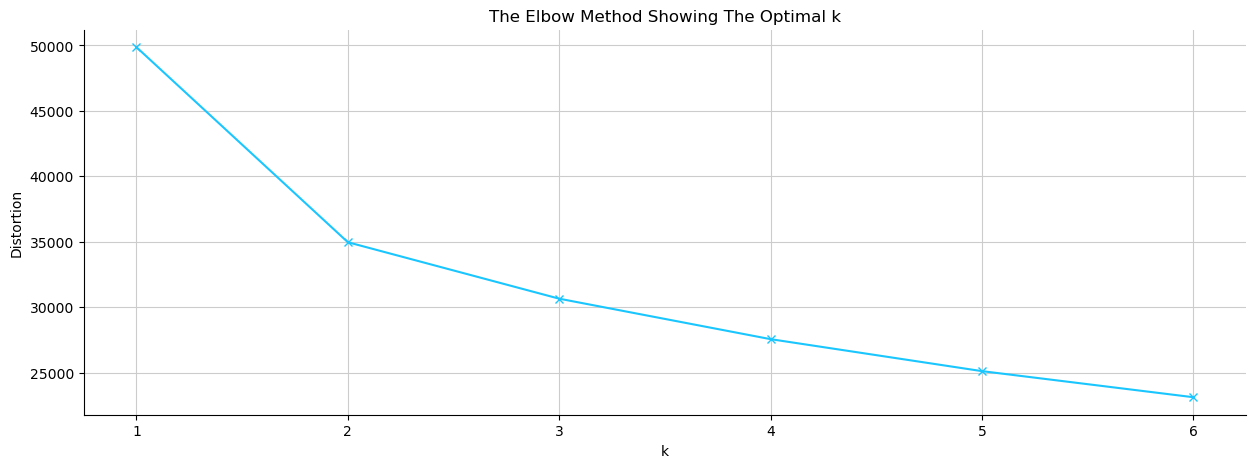

In [76]:
#plot elbow graph
plt.figure(figsize=(15,5))
plt.rcParams.update({'axes.grid': True})
plt.plot(K, distortions, 'bx-', color=palette[-1])
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method Showing The Optimal k')
sns.despine()
plt.show()

Using the above plot, we will choose the value of k to be 4.

## 4.2. Clustering Algorithm

Clustering will be performed using the K-means algorithm, which assumes the clusters are somehow spherical in shape.

In [77]:
#clustering data and adding the output to the data dataframe
clusters = KMeans(n_clusters=4, random_state=202).fit(reduced_data)
data["Personality"]= clusters.labels_
dataCopy["Personality"]= clusters.labels_

data.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Age,Children_Count,Family_Size,Customer_For,Spendings,Purchases,Accepted_Campaigns,Marital_Status_Single,Marital_Status_Taken,Personality
0,-0.893586,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,...,1.018352,-1.264598,-1.758359,1.527721,1.676245,1.317945,-0.43916,1.349603,-1.349603,3
1,-0.893586,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,...,1.274785,1.404572,0.449070,-1.189011,-0.963297,-1.159273,-0.43916,1.349603,-1.349603,1
2,-0.893586,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,...,0.334530,-1.264598,-0.654644,-0.206048,0.280110,0.796425,-0.43916,-0.740959,0.740959,3
3,-0.893586,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,...,-1.289547,0.069987,0.449070,-1.060584,-0.920135,-0.898513,-0.43916,-0.740959,0.740959,1
4,0.571657,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,...,-1.033114,0.069987,0.449070,-0.951915,-0.307562,0.535666,-0.43916,-0.740959,0.740959,2


## 4.3. Algorithm Evaluation

To get a sense of whether our clustering algorithm provides reasonable results, we can look at the pie and bar plots of the clusters to see how they're distributed.

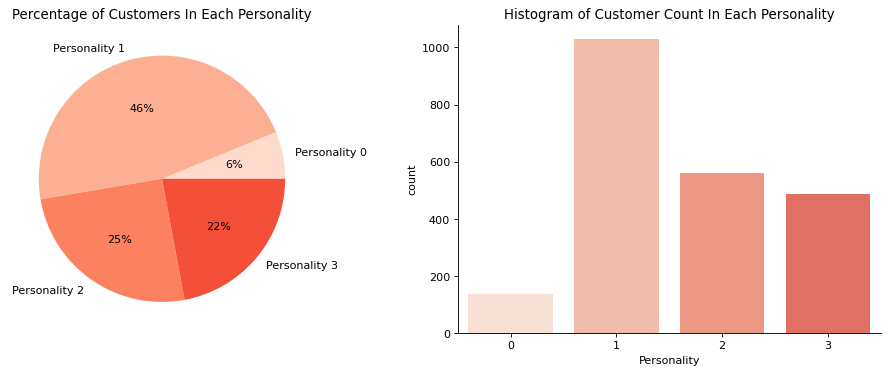

In [78]:
#define labels
labels = ['Personality 0', 'Personality 1', 'Personality 2', 'Personality 3']
counts= []

#compute counts
for i in range(4):
  counts.append(len(data[data["Personality"]==i]))

plt.figure(figsize=(15, 5), dpi=80)
plt.rcParams.update({'axes.grid': False})

#pie plot
ax1 = plt.subplot2grid((1,2),(0,0))
ax1.set_title("Percentage of Customers In Each Personality")
plt.pie(counts, labels = labels, autopct='%.0f%%')

#bar plot
ax1 = plt.subplot2grid((1,2), (0, 1))
ax1.set_title("Histogram of Customer Count In Each Personality")
sns.countplot(x=data["Personality"], alpha=.9, ax=ax1)
sns.despine()

plt.show()


From the bar plot, we can see that the data seem to be sampled from a normal distribution, which makes sense since this is a customer segmentation problem.

# 5. Data Analysis

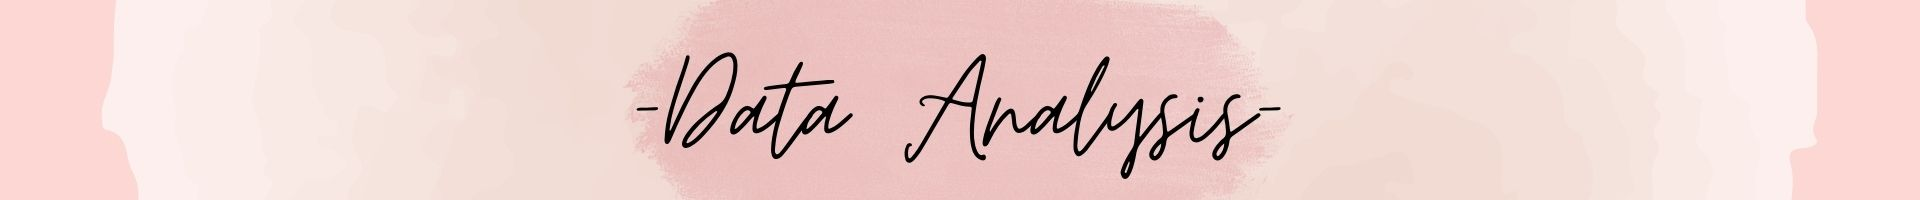

It's time to find out the special characteristics of each cluster. To do that, we'll study their demographics and behaviors against different features.

## 5.1. Demographics

### 5.1.1. Age

To study the demographics of the different personality groups, we'll first take a look on their age distributions.

C:\Users\mnkre\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


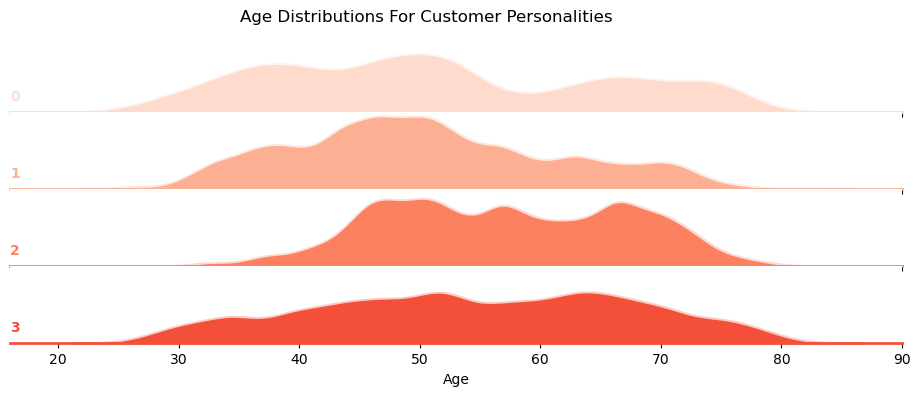

In [79]:
# Initialize the FacetGrid object
g = sns.FacetGrid(dataCopy,
                  row="Personality",
                  hue="Personality",
                  size= 1, aspect=10,
                  # palette=palette
                  )

# Draw the densities in a few steps
g.map(sns.kdeplot, "Age",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Age", clip_on=False, color="w", lw=2, bw_adjust=.5,alpha=.7)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(Age, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Age")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0.01)

# Remove axes details that don't play well with overlap
g.fig.suptitle('Age Distributions For Customer Personalities')
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

Conclusion:


*   Personalities 0 & 3: Have more young people than old people
*   Personality 1: Has a wide and nearly even distribution, which show a diverse variation in age groups.
*   Personality 2: mainly consists of older people compared to other personalities

To validate this, let's calculate some stats.



In [80]:
#personality 0 age stats
d= dataCopy[dataCopy["Personality"]==0]
perc= (len(d[d["Age"]<60])/len(d))*100
print("Percentage of customer below 60 in personality 0= {:.2f}% ".format(perc))

#personality 1 age stats
d= dataCopy[dataCopy["Personality"]==1]
perc= (len(d[d["Age"]<55])/len(d))*100
print("Percentage of customer below 55 in personality 1= {:.2f}% ".format(perc))

#personality 2 age stats
d= dataCopy[dataCopy["Personality"]==2]
perc= (len(d[d["Age"]>50])/len(d))*100
print("Percentage of customer above 50 in personality 2= {:.2f}% ".format(perc))

#personality 3 age stats
d= dataCopy[dataCopy["Personality"]==3]
perc= (len(d[d["Age"]<60])/len(d))*100
print("Percentage of customer below 60 in personality 3= {:.2f}% ".format(perc))

Percentage of customer below 60 in personality 0= 69.34% 
Percentage of customer below 55 in personality 1= 67.61% 
Percentage of customer above 50 in personality 2= 69.59% 
Percentage of customer below 60 in personality 3= 60.86% 


### 5.1.2. Family Breakdown

To analyze based on family shape, we'll consider 2 aspects; the family size and the number of children.

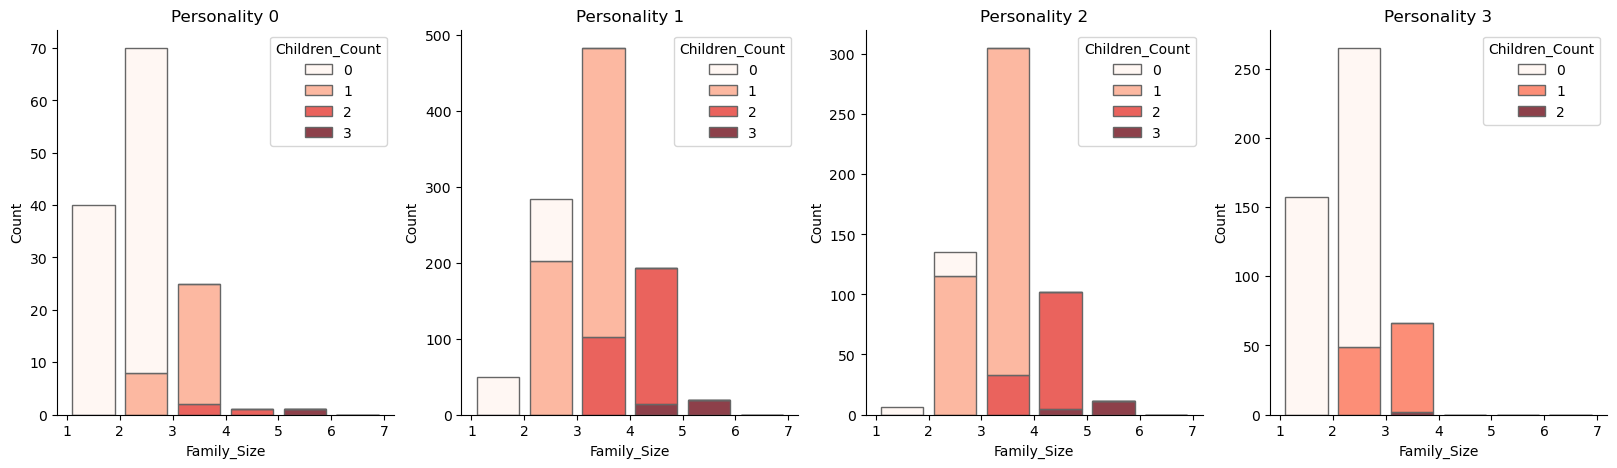

In [82]:
plt.figure(figsize=(20, 5))

#plotting a histogram of family size showing children count in each bin
for i in range(4):
  ax1 = plt.subplot2grid((1,4),(0,i))
  ax1.set_title("Personality "+str(i))
  sns.histplot(
      dataCopy[dataCopy["Personality"]==i],
      x="Family_Size",
      hue="Children_Count",
      multiple="stack",
      palette="Reds",
      edgecolor=".4",
      bins= list(range(1,8)),
      shrink= .8
  )
  sns.despine()


Conclusion:

1.   Personality 0:
  *  The majority of customers have 1-2 kids and a partner.
  *  A considerable percentage are single parents.
2.   Personality 1: 
  *  The majority of customers have no kids (or 1 at most).
  *  Almost equal numbers of single and non-single customers. 
  *  A considerable percentage are living alone.
  *  Very few single parents. 
  *  Max family size is 3, which is fewer than the other segments.
3.   Personality 2: 
  *  The majority of customers have 1-2 kids and a partner. 
  *  Relatively fewer single parents.
4.   Personality 3:
  *  The vast majority have 0 kids, followed by 1 kid.
  *  A considerable percentage are living alone.
  *  Very few single parents. 

Time for some stats.

In [83]:
#personality 0 kids stats
d= dataCopy[dataCopy["Personality"]==0]
perc= ((len(d[d["Children_Count"]==1]) + len(d[d["Children_Count"]==2]))/len(d))*100
print("Percentage of customers having 1-2 kids in personality 0 = {:.2f}% ".format(perc))

#personality 1 kids stats
d= dataCopy[dataCopy["Personality"]==1]
perc= ((len(d[d["Children_Count"]==0]))/len(d))*100
print("Percentage of customers having 0 kids in personality 1 = {:.2f}% ".format(perc))

#personality 2 kids stats
d= dataCopy[dataCopy["Personality"]==2]
perc= ((len(d[d["Children_Count"]==1]) + len(d[d["Children_Count"]==2]))/len(d))*100
print("Percentage of customers having 1-2 kids in personality 2 = {:.2f}% ".format(perc))

#personality 3 kids stats
d= dataCopy[dataCopy["Personality"]==3]
perc= ((len(d[d["Children_Count"]==0]))/len(d))*100
print("Percentage of customers having 0 kids in personality 3 = {:.2f}% ".format(perc))

Percentage of customers having 1-2 kids in personality 0 = 24.82% 
Percentage of customers having 0 kids in personality 1 = 12.74% 
Percentage of customers having 1-2 kids in personality 2 = 92.49% 
Percentage of customers having 0 kids in personality 3 = 76.43% 


In [84]:
#single parents in personality 0
d= dataCopy[dataCopy["Personality"]==0]
perc= (len(d[d["Marital_Status"]=="Single"])/len(dataCopy[dataCopy["Marital_Status"]=="Single"]))*100
print("Percentage of single parents belonging to personality 0= {:.2f}% ".format(perc))

Percentage of single parents belonging to personality 0= 6.38% 


### 5.1.3. Education

Next, we will examine the educational level of the different customer personalities using a histogram.

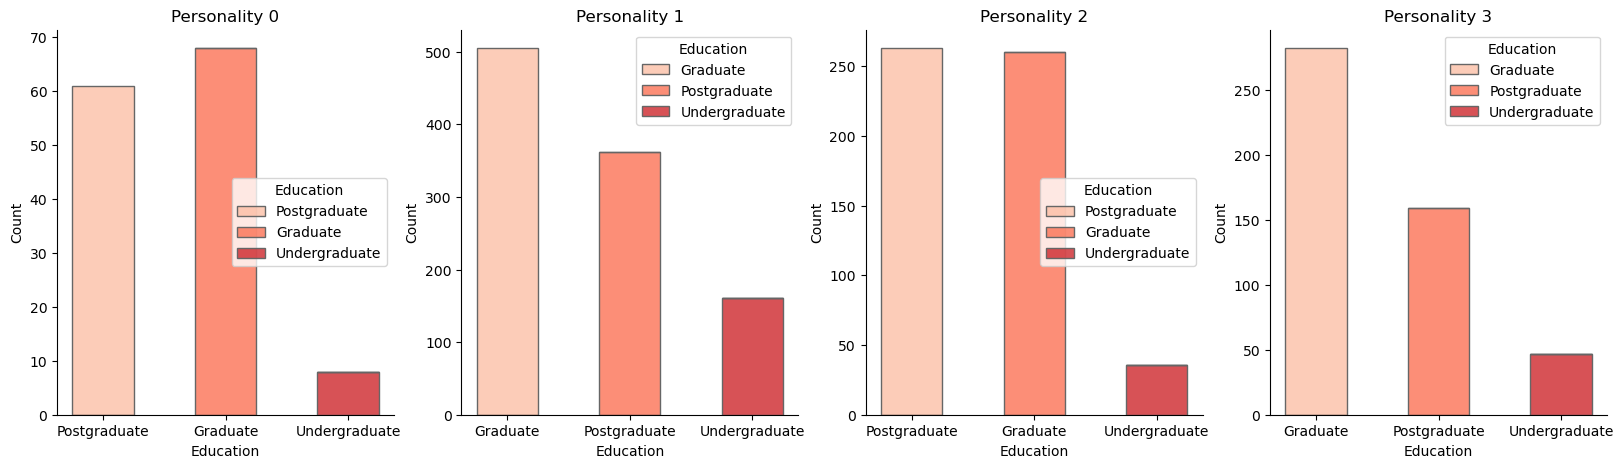

In [86]:
plt.figure(figsize=(20, 5))

#plotting a histogram of family size showing children count in each bin
for i in range(4):
  ax1 = plt.subplot2grid((1,4),(0,i))
  ax1.set_title("Personality "+str(i))
  sns.histplot(
      dataCopy[dataCopy["Personality"]==i],
      x="Education",
      hue= "Education",
      multiple="stack",
      palette="Reds",
      edgecolor=".4",
      shrink= .5
  )
  sns.despine()

Conclusion:


*   Personality 0 has the largest percentage of undergraduates.
*   Personalities 2 & 3 have very similar education distributions.
*   The education distributions don't really help in differentiating between the different segments.





### 5.1.4. Income

Now we'll visualize the income distributions of the different segments.

C:\Users\mnkre\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


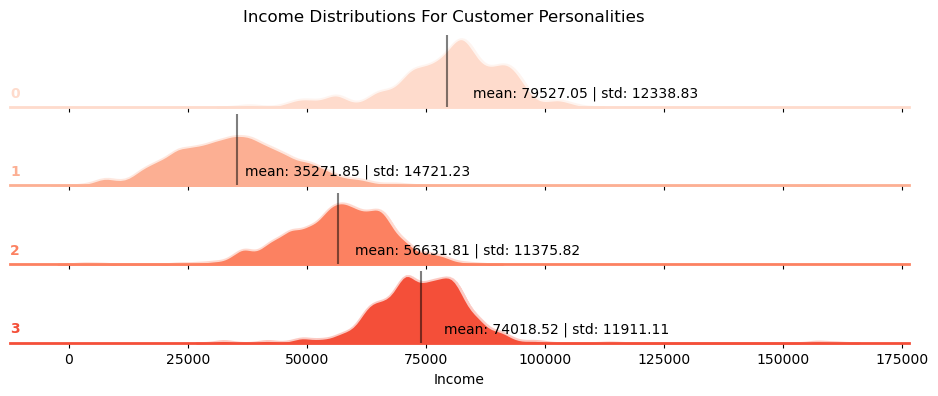

In [87]:
# Initialize the FacetGrid object
g = sns.FacetGrid(dataCopy,
                  row="Personality",
                  hue="Personality",
                  size= 1, aspect=10,
                  # palette=palette
                  )

# Draw the densities in a few steps
g.map(sns.kdeplot, "Income",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Income", clip_on=False, color="w", lw=2, bw_adjust=.5, alpha=.7)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(Income, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Income")

# Add vertical lines for mean age on each plot
def vertical_mean_line_survived(x, **kwargs):
    plt.axvline(x.mean(), linestyle ="-", 
                color = "black", alpha=.5)
    txkw = dict(size=10, color = "black")
    tx = "mean: {:.2f} | std: {:.2f}".format(x.mean(),x.std())
    ax = plt.gca()
    ax.text(0.06+x.mean()/175000, .2, tx, color="black", size= 10,
            ha="left", va="center", transform=ax.transAxes)
    # plt.text(x.mean()+1, 0.0052, tx, **txkw)

g.map(vertical_mean_line_survived, 'Income')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0.1)

# Remove axes details that don't play well with overlap
g.fig.suptitle('Income Distributions For Customer Personalities')
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

Conclusion:

1.   Personality 0 (Low):
  *   Lowest average income group
  *   Highest variation in income
2.   Personality 1 (High):
  *   Relatively higher average income group
  *   Average variation in income
3.   Personality 2 (Average):
  *   Average income group
  *   Average variation in income
4.   Personality 3 (High):
  *  Highest average income group
  *  Similar to personality 1 group with slightly more variance

## 5.2. Business Related

We will focus here on the business-related aspect of the customer's personality to get more insights.

### 5.2.1. Products Breakdown

We will use a simple pie chart to visualize the types of products frequently bought by the customers.

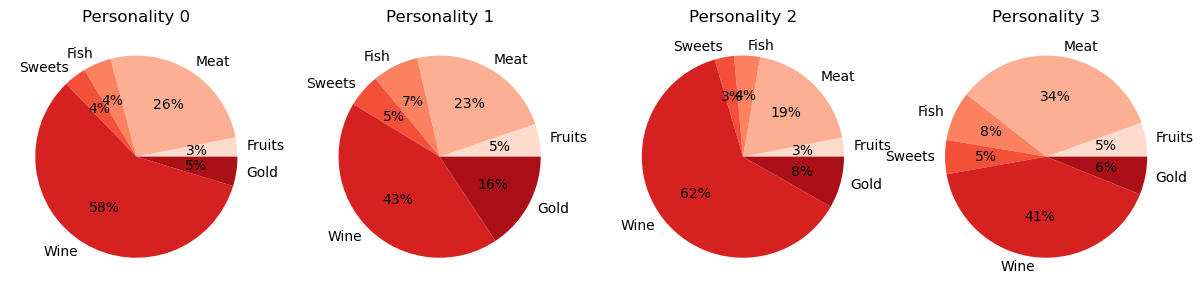

In [88]:
#define labels
labels = ['Fruits', 'Meat', 'Fish', 'Sweets', 'Wine', 'Gold']
plt.figure(figsize=(15, 10), dpi=100)

#compute counts
for i in range(4):
  counts= []
  #getting the data of the current segment
  d= dataCopy[dataCopy["Personality"]==i]

  #computing counts
  counts.append(d["MntFruits"].sum())
  counts.append(d["MntMeatProducts"].sum())
  counts.append(d["MntFishProducts"].sum())
  counts.append(d["MntSweetProducts"].sum())
  counts.append(d["MntWines"].sum())
  counts.append(d["MntGoldProds"].sum())

  #plotting chart
  ax1 = plt.subplot2grid((1,4),(0,i))
  ax1.set_title("Personality "+str(i))
  plt.pie(counts, labels = labels, autopct='%.0f%%')

plt.show()

From the above plots, we can see that:
*  The percentage of spendings on primary goods such as fruits, fish and sweets is very close across all segments.
*  Spendings on meat vary across segments.
* Personality 0 spends relatively more on gold compared to other segments.
* Personality 2 spends the most on wine.


### 5.2.2. Spendings

To examine the value added by the customers, we will plot the purchases against the spendings for each segment.

C:\Users\mnkre\anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


<Figure size 400x400 with 0 Axes>

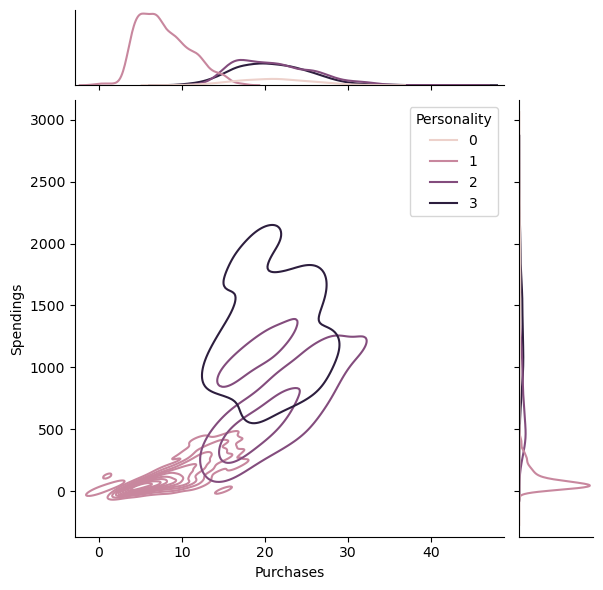

In [89]:
# Show the joint distribution using kernel density estimation
plt.figure(figsize=(5, 5), dpi=80)
g = sns.jointplot(data=dataCopy, x="Purchases", y="Spendings", hue="Personality",kind="kde")
sns.despine()

Conclusion:
1.   Personality 0: Few purchases, low spendings.
2.   Personality 1: Relatively higher spendings, meaning that they buy more expensive products. 
3.   Personalities 1,2,3: Similar average purchases. 
4. Personality 3: Not clearly visible in the plot due to the limited number of data. We need more plots.



We will also plot the family size against the spendings for each segment.

<Figure size 400x400 with 0 Axes>

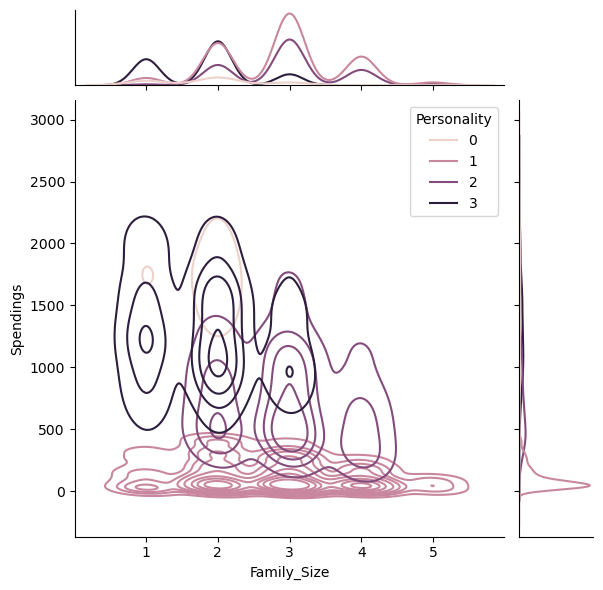

In [90]:
plt.figure(figsize=(5, 5), dpi=80)
g = sns.jointplot(data=dataCopy, x="Family_Size", y="Spendings", hue="Personality",kind="kde")
sns.despine()

The above plot supports the previous conclusions made about the family sizes. 


We will now plot the customer_for against the spendings for each segment.

C:\Users\mnkre\anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


<Figure size 400x400 with 0 Axes>

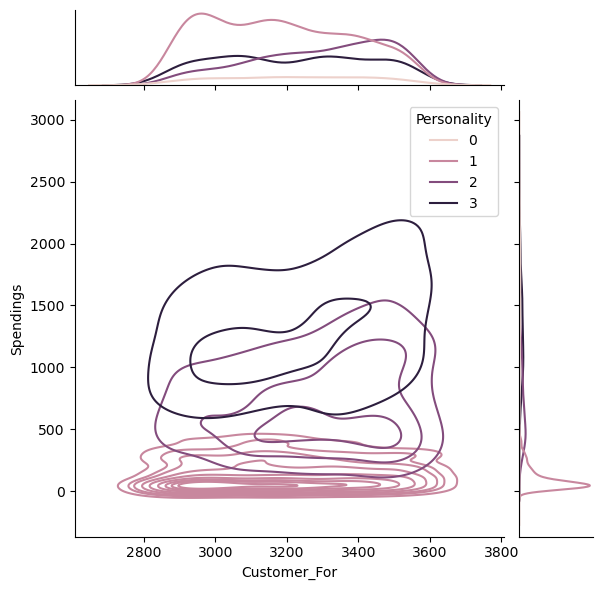

In [91]:
plt.figure(figsize=(5, 5), dpi=80)
g = sns.jointplot(data=dataCopy, x="Customer_For", y="Spendings", hue="Personality",kind="kde")
sns.despine()

From the above plot, we can see that no new customers from personality 2 have joined recently, if though they have the highest spendings.

## 5.3. Behavioural

### 5.3.1. Response To Campaigns

Finally, we will examine the customer's reactions to the company's campaigns in terms of how many campaigns have they accepted.

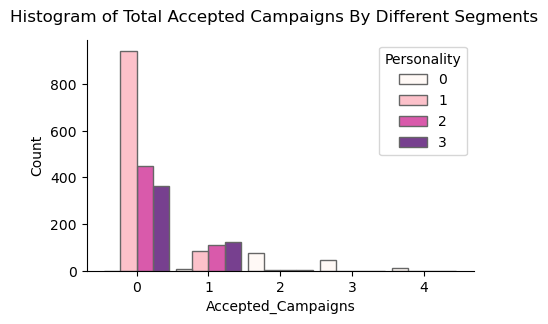

In [92]:
f= plt.figure(figsize=(5, 3))
f.suptitle("Histogram of Total Accepted Campaigns By Different Segments")
sns.histplot(dataCopy, x="Accepted_Campaigns", hue= "Personality", multiple="dodge", palette="RdPu", edgecolor=".4", discrete= True, shrink= .9)
sns.despine()

Conclusion:

*   Personalities 0, 1 & 2: Majority accepted 0 campaigns. Very few accepted only 1.
*   Personality 3: Majority accepted 2 campaigns. Some accepted 3 or 4. Very few accepted only 1. No one accepted 0 campaigns.



# 6. Summary

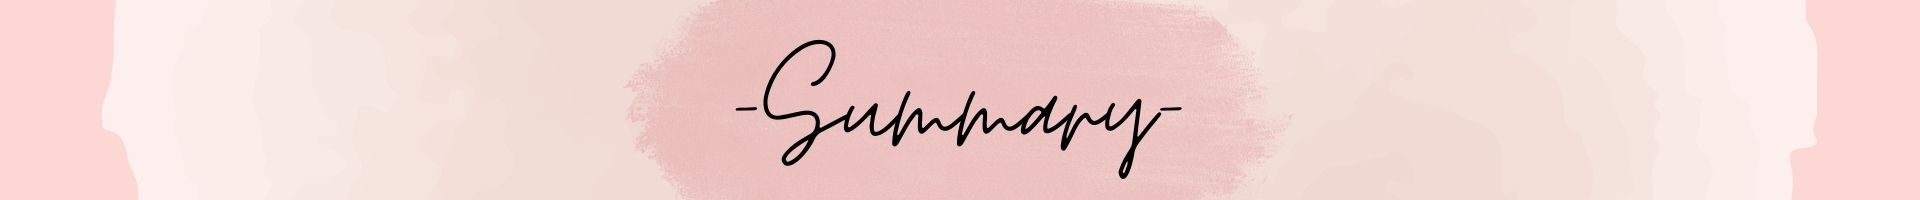

We finally reached the end of the analysis. Here is a summary of the main features of each customer segment/personality:

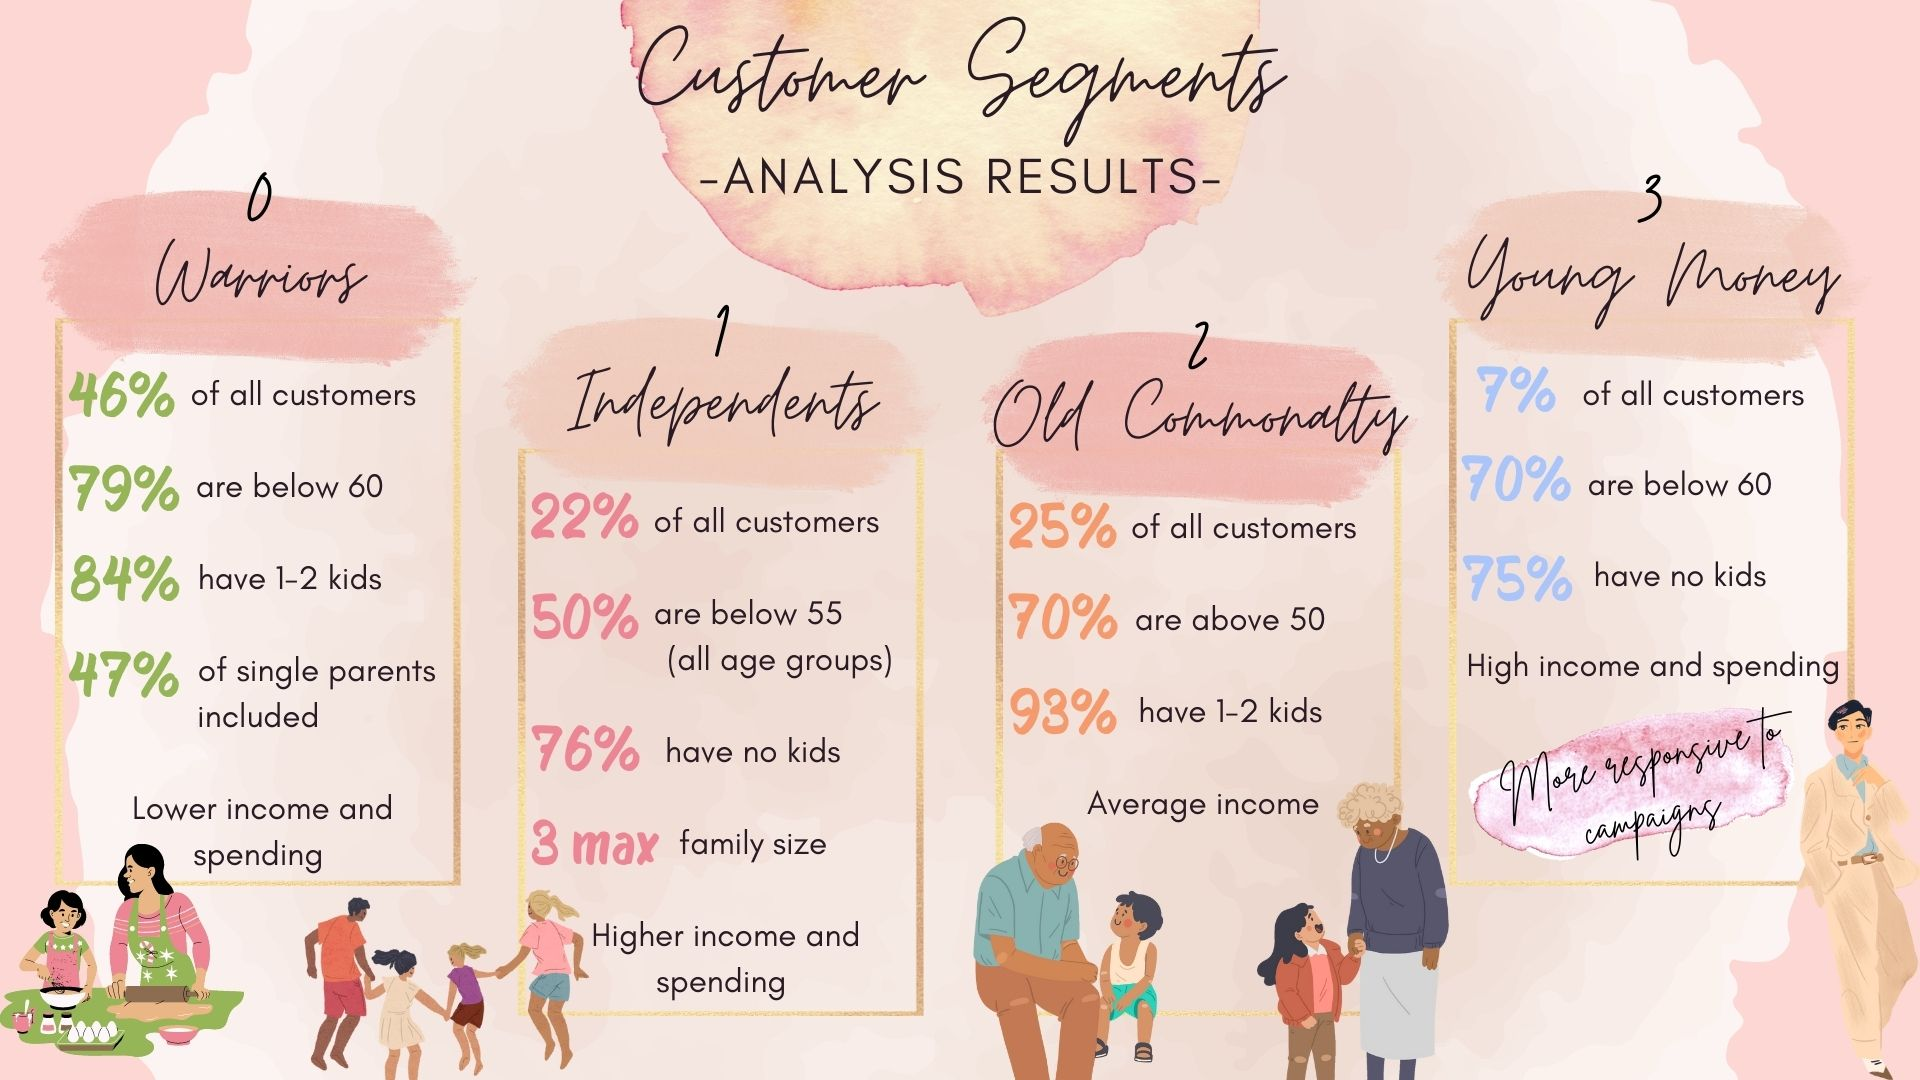